In [126]:
import warnings
warnings.filterwarnings('ignore')

# Sklearn을 이용한 DTM / TF-IDF

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = [
    'I love you',
    'you know i want your love',
    'what should i do'
]

vector = CountVectorizer()
print(vector.fit_transform(corpus).toarray())
print(vector.vocabulary_)

[[0 0 1 0 0 0 1 0]
 [0 1 1 0 1 0 1 1]
 [1 0 0 1 0 1 0 0]]
{'love': 2, 'you': 6, 'know': 1, 'want': 4, 'your': 7, 'what': 5, 'should': 3, 'do': 0}


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = [
    'I love you',
    'you know i want your love',
    'what should i do'
]

tfidf = TfidfVectorizer(stop_words={'do'}).fit(corpus)
print(tfidf.transform(corpus).toarray())
print(tfidf.vocabulary_)

[[0.         0.70710678 0.         0.         0.         0.70710678
  0.        ]
 [0.49047908 0.37302199 0.         0.49047908 0.         0.37302199
  0.49047908]
 [0.         0.         0.70710678 0.         0.70710678 0.
  0.        ]]
{'love': 1, 'you': 5, 'know': 0, 'want': 3, 'your': 6, 'what': 4, 'should': 2}


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = [
    '품질 정말 대박',
    '써보니 품질 믿을만 하네요',
    '품질도 좋은데 서비스도 좋아요'
]

tfidf = TfidfVectorizer().fit(corpus)
print(tfidf.transform(corpus).toarray())
print(tfidf.vocabulary_)

[[0.62276601 0.         0.         0.         0.62276601 0.
  0.         0.4736296  0.         0.        ]
 [0.         0.52863461 0.         0.52863461 0.         0.
  0.         0.40204024 0.         0.52863461]
 [0.         0.         0.5        0.         0.         0.5
  0.5        0.         0.5        0.        ]]
{'품질': 7, '정말': 4, '대박': 0, '써보니': 3, '믿을만': 1, '하네요': 9, '품질도': 8, '좋은데': 6, '서비스도': 2, '좋아요': 5}


# 문서 유사도 측정

## 1. CountVectorizer

In [7]:
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
np.random.seed(0)

from konlpy.tag import Okt
okt = Okt()

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

# tokenizer : 문장에서 색인어 추출을 위해 명사, 동사, 알파벳 .. 
def tokenizer(raw, pos=['Noun', 'Alpha', 'Verb', 'Number'], stopword=[]):
    return [
        word for word, tag in okt.pos(
        raw,
        norm=True,
        stem=True
        )
        if len(word) > 1 and tag in pos and word not in stopword
    ]

# test sentence
rawdata = [
    '[커버스토리] 10년 후에 더 잘 나가는 미래 보장 유망직업',
    '멀지않은 미래에 이 직업 뜬다 - 직업별 전망, 연봉, 만족도 Top30 - 에듀진',
    '[좌충우돌 일자리]연봉 1억4000 이하로 떨어지지 않는 직업',
    '제4차 산업혁명 시대, 미래사회 변화에 대한 전략적 대응 방안 모색',
    '2024년 미래유망직업 25가지, 1위는 PA, 소프트웨어 개발자가 가장 인기있는 이유',
    '[TECH웨이브] 올해 가장 주목받을 IT 기술은 AI와 메타버스'
]


In [11]:
vectorize = CountVectorizer(
    tokenizer=tokenizer, 
    min_df=2)

X = vectorize.fit_transform(rawdata)

print(X.toarray())

features = vectorize.get_feature_names()
print(features)

[[0 1 0 0 1 1]
 [0 1 1 1 0 2]
 [0 0 1 1 0 1]
 [0 1 0 0 0 0]
 [1 1 0 0 1 1]
 [1 0 0 0 0 0]]
['가장', '미래', '않다', '연봉', '유망', '직업']


In [12]:
srch = [t for t in tokenizer('미래 가장 인기있는 직업') if t in features]
print(srch)

srch_dtm = np.asarray(X.toarray())[:, [
    vectorize.vocabulary_.get(i) for i in srch
]]

['미래', '가장', '직업']


In [13]:
srch_dtm

array([[1, 0, 1],
       [1, 0, 2],
       [0, 0, 1],
       [1, 0, 0],
       [1, 1, 1],
       [0, 1, 0]])

In [14]:
score = srch_dtm.sum(axis=1)
print(score)

for i in score.argsort()[::-1]:
    if score[i] > 0:
        print('{} / score : {}'.format(rawdata[i], score[i]))

[2 3 1 1 3 1]
2024년 미래유망직업 25가지, 1위는 PA, 소프트웨어 개발자가 가장 인기있는 이유 / score : 3
멀지않은 미래에 이 직업 뜬다 - 직업별 전망, 연봉, 만족도 Top30 - 에듀진 / score : 3
[커버스토리] 10년 후에 더 잘 나가는 미래 보장 유망직업 / score : 2
[TECH웨이브] 올해 가장 주목받을 IT 기술은 AI와 메타버스 / score : 1
제4차 산업혁명 시대, 미래사회 변화에 대한 전략적 대응 방안 모색 / score : 1
[좌충우돌 일자리]연봉 1억4000 이하로 떨어지지 않는 직업 / score : 1


## 2. TfidfVectorizer

In [15]:
vectorize = TfidfVectorizer(
    tokenizer=tokenizer, 
    min_df=2, 

    sublinear_tf=True
)
X = vectorize.fit_transform(rawdata)

print('fit_transform, (sentence {}, feature {})'.format(X.shape[0], X.shape[1]))

print(X.toarray())

features = vectorize.get_feature_names()

fit_transform, (sentence 6, feature 6)
[[0.         0.50568743 0.         0.         0.69897098 0.50568743]
 [0.         0.36066062 0.49851211 0.49851211 0.         0.61065151]
 [0.         0.         0.62951441 0.62951441 0.         0.4554374 ]
 [0.         1.         0.         0.         0.         0.        ]
 [0.57289616 0.41447556 0.         0.         0.57289616 0.41447556]
 [1.         0.         0.         0.         0.         0.        ]]


In [16]:
print(features)

['가장', '미래', '않다', '연봉', '유망', '직업']


In [18]:
srch = [t for t in tokenizer('미래 가장 인기있는 직업') if t in features]
print(srch)

srch_dtm = np.asarray(X.toarray())[:, [
    vectorize.vocabulary_.get(i) for i in srch
]]

print(srch_dtm)

['미래', '가장', '직업']
[[0.50568743 0.         0.50568743]
 [0.36066062 0.         0.61065151]
 [0.         0.         0.4554374 ]
 [1.         0.         0.        ]
 [0.41447556 0.57289616 0.41447556]
 [0.         1.         0.        ]]


In [19]:
# 문장의 feature 합계 점수 
score = srch_dtm.sum(axis=1)
print(score)

for i in score.argsort()[::-1]:
    if score[i] > 0:
        print('{} / score : {}'.format(rawdata[i], score[i]))

[1.01137487 0.97131213 0.4554374  1.         1.40184728 1.        ]
2024년 미래유망직업 25가지, 1위는 PA, 소프트웨어 개발자가 가장 인기있는 이유 / score : 1.4018472787288918
[커버스토리] 10년 후에 더 잘 나가는 미래 보장 유망직업 / score : 1.0113748685853126
[TECH웨이브] 올해 가장 주목받을 IT 기술은 AI와 메타버스 / score : 1.0
제4차 산업혁명 시대, 미래사회 변화에 대한 전략적 대응 방안 모색 / score : 1.0
멀지않은 미래에 이 직업 뜬다 - 직업별 전망, 연봉, 만족도 Top30 - 에듀진 / score : 0.9713121343309381
[좌충우돌 일자리]연봉 1억4000 이하로 떨어지지 않는 직업 / score : 0.45543739639154


# Word2Vec
- 비지도 학습에 해당
- 단어 간 유사성을 파악할 수 있음
- 주변의 단어로 특정단어를 예측하거나 특정단어로 주변을 예측

In [40]:
import sys
sys.executable

'/Users/hayeon/opt/anaconda3/bin/python'

In [45]:
!pip install  --upgrade gensim --pre

In [47]:
import gensim

In [56]:
from gensim.models import Word2Vec

sentences = [
        ['this', 'is', 'a',   'good',      'product'],
        ['it',   'is', 'a',   'excellent', 'produdct'],
        ['it',   'is', 'a',   'bad',       'product'],
        ['that', 'is', 'the', 'worst',     'product']
]

# 문장을 이용하여 단어와 벡터 생성
model = Word2Vec(sentences, size=300, window=3, min_count=1, workers=1)

# 단어벡터를 구하기
word_vectors = model.wv

vocabs = word_vectors.vocab.keys()
word_vectors_list = [word_vectors[v] for v in vocabs]

# 단어 간 유사도 확인
print(word_vectors.similarity(w1='bad', w2='worst'))

0.09422431


In [57]:
print(vocabs)

dict_keys(['this', 'is', 'a', 'good', 'product', 'it', 'excellent', 'produdct', 'bad', 'that', 'the', 'worst'])


In [58]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
xys = pca.fit_transform(word_vectors_list)
xs = xys[:,0]
ys = xys[:,1]

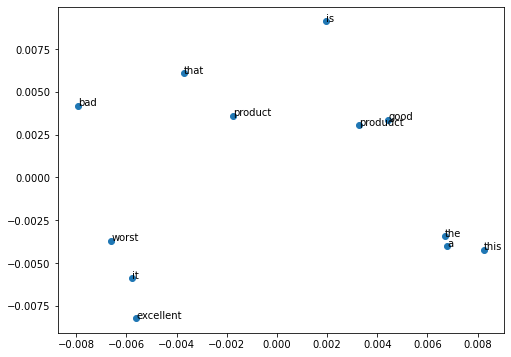

In [59]:
# 단어와 2차원 y축의 값, y축으로 2차원 그래프를 그린다
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(xs, ys, marker='o')
for i, v in enumerate(vocabs):
    plt.annotate(v, xy=(xs[i], ys[i]))

# 영화리뷰 활용한 Tfidf

In [109]:
import requests 
import pandas as pd
from bs4 import BeautifulSoup
import re
import time

pre = 'https://movie.naver.com/movie/bi/mi/pointWriteFormList.naver?code=183854&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page=1'

review = []
rate = []

cnt = 0
for i in range(1, 100):
    time.sleep(0.1)
    cnt = cnt + 1
    #print(cnt)
    url = pre + str(i)
    res = requests.get(url)
    soup = BeautifulSoup(res.content, 'html.parser')
    
    id_list = []
    id_pre = '_filtered_ment_'
    
    for i in range(10):
        id_list.append(id_pre + str(i))
        
    for id in id_list:
        review.append(soup.find('span', {'id':id}).get_text().strip())
    
    rate_list = []
    rate_list = (soup.select('div.star_score > em'))
    
    for r in rate_list:
        r = int(re.sub('<.+?>', '', str(r)))
        rate.append(r)
    

df = pd.DataFrame({'review' : review, 'rate' : rate})

In [110]:
df

,review,rate
0,김성오 악역만 보다가 이런 연기 보니까 색다르고 ㅋㅋ 연기 너무 잘하구~ 능글맞은데...,10
1,코믹과 스릴러를 오가는 재미,10
2,독특한 스토리의 영화였어요. 시실리2km랑 챠우도 봤는데 이 감독님 영화는 항상 독...,9
3,넘 재밌엇어요 ㅋㅋㅋ 오랜만에 생각없이 많이 웃고왔네요,10
4,병맛재미로보는거죠~,8
...,...,...
985,영화를 정말 재밌게 봤습니다. 94년도에 헐리웃 쥬라기공원이 상영할 무렵 동시에 한...,10
986,재미만 있는데 왜 난리들이지;; 재미없다고 쓰는 알바도 있나 ; 신원조회94에 2...,8
987,배우들의 열연에 비해 스토리가 조금 산으로 가는 경향이 있어서 부조화스럽고 어색한 ...,3
988,이거 병맛 장난 아님. 겁나 재밌네 ㅎㅎ,10


In [111]:
df.to_csv('review.csv')

In [112]:
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

In [113]:
train_data = pd.read_csv('review.csv')
train_data[:5]

,Unnamed: 0,review,rate
0,0,김성오 악역만 보다가 이런 연기 보니까 색다르고 ㅋㅋ 연기 너무 잘하구~ 능글맞은데...,10
1,1,코믹과 스릴러를 오가는 재미,10
2,2,독특한 스토리의 영화였어요. 시실리2km랑 챠우도 봤는데 이 감독님 영화는 항상 독...,9
3,3,넘 재밌엇어요 ㅋㅋㅋ 오랜만에 생각없이 많이 웃고왔네요,10
4,4,병맛재미로보는거죠~,8


In [114]:
train_data = train_data.dropna(how='any')
print(train_data.isnull().values.any())

False


In [115]:
train_data['review'] = train_data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣] ", "")
train_data[:5]

<ipython-input-115-be9eadac1107>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['review'] = train_data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣] ", "")


,Unnamed: 0,review,rate
0,0,김성오 악역만 보다가 이런 연기 보니까 색다르고 ㅋㅋ 연기 너무 잘하구능글맞은데 매력있어,10
1,1,코믹과 스릴러를 오가는 재미,10
2,2,독특한 스토리의 영화였어요시실리2km랑 챠우도 봤는데 이 감독님 영화는 항상 독특한...,9
3,3,넘 재밌엇어요 ㅋㅋㅋ 오랜만에 생각없이 많이 웃고왔네요,10
4,4,병맛재미로보는거죠~,8


In [141]:
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', 
            '와', '한', '하다', 'ㅋㅋ', '~', '만', '다', '?', '요', '로', '을', '나', '..', '...', '.', 
            '에서', '게']

okt = Okt()
tokenized_data = []

for sentence in train_data['review']:
    temp_X = okt.morphs(sentence, stem=True)
    temp_X = [word for word in temp_X if not word in stopwords]
    tokenized_data.append(temp_X)

리뷰의 최대 길이 : 47
리뷰의 평균 길이 : 13.67117585848075


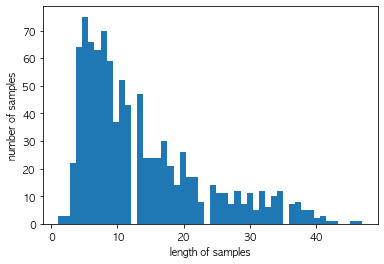

In [142]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :', max(len(l) for l in tokenized_data))
print('리뷰의 평균 길이 :', sum(map(len, tokenized_data)) / len(tokenized_data))
plt.hist([len(s) for s in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [143]:
from gensim.models import Word2Vec
model = Word2Vec(sentences = tokenized_data, size=100, window=5, min_count=5, workers=4, sg=0)
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

(491, 100)

In [153]:
print(model.wv.most_similar("B"))
print(model.wv.most_similar("양동근"))
print(model.wv.most_similar("재미"))
print(model.wv.most_similar("웃음"))
print(model.wv.most_similar("병맛"))

[('영화', 0.9957132935523987), ('보다', 0.9950066804885864), ('너무', 0.9945127367973328), ('웃다', 0.9944669604301453), ('없이', 0.9941291213035583), ('안', 0.9937471151351929), ('스토리', 0.9937336444854736), ('진짜', 0.9934215545654297), ('웃기다', 0.993237316608429), ('재밌다', 0.9929071664810181)]
[('보다', 0.9928794503211975), ('영화', 0.9921560287475586), ('웃기다', 0.9911932945251465), ('웃다', 0.9911081790924072), ('B', 0.991015613079071), ('있다', 0.990937352180481), ('너무', 0.9907797574996948), ('안', 0.9906123280525208), ('없이', 0.9904829859733582), ('좋다', 0.9903185367584229)]
[('영화', 0.9874536991119385), ('좋다', 0.9872433543205261), ('급', 0.9866722822189331), ('웃다', 0.9866653680801392), ('너무', 0.986138105392456), ('안', 0.9860900640487671), ('보다', 0.9857213497161865), ('없이', 0.9854357242584229), ('재밌다', 0.984679102897644), ('님', 0.9846770763397217)]
[('보다', 0.9862520694732666), ('급', 0.9853613972663879), ('있다', 0.9852559566497803), ('웃다', 0.9851240515708923), ('안', 0.984874963760376), ('많다', 0.9847986698150635

In [135]:
from sklearn.decomposition import PCA
from matplotlib import font_manager, rc

In [144]:
model = Word2Vec(sentences=tokenized_data, min_count=35, workers=4, sg=0)

word_vectors = model.wv

vocabs = word_vectors.vocab.keys()
word_vectors_list = [word_vectors[v] for v in vocabs]

In [145]:
print(vocabs)

dict_keys(['보다', '이렇다', '연기', '너무', '있다', '재미', '스토리', '영화', '이다', '감독', '님', '재밌다', '넘다', 'ㅋㅋㅋ', '오랜', '생각', '없이', '웃다', '병맛', '나오다', '배우', '좋다', '양동근', '안', '하고', 'ㅋ', '진짜', '기대', '아', '같다', '개', '많다', '볼', 'ㅋㅋㅋㅋ', '고', '보고', '웃기다', '정말', '내', '!', '돈', '평점', '점', '코미디', '않다', '아니다', '만들다', '거', '노잼', '더', '자다', '되다', '없다', '간만', '아깝다', '급', '모르다', '왜', '그냥', '지', '저', 'B', '감성', '웃음', '시간', '비급', '재미있다'])


In [146]:
pca = PCA(n_components=2)
xys = pca.fit_transform(word_vectors_list)
xs = xys[:,0]
ys = xys[:,1]

In [139]:
plt.rcParams['font.family'] = 'AppleGothic'

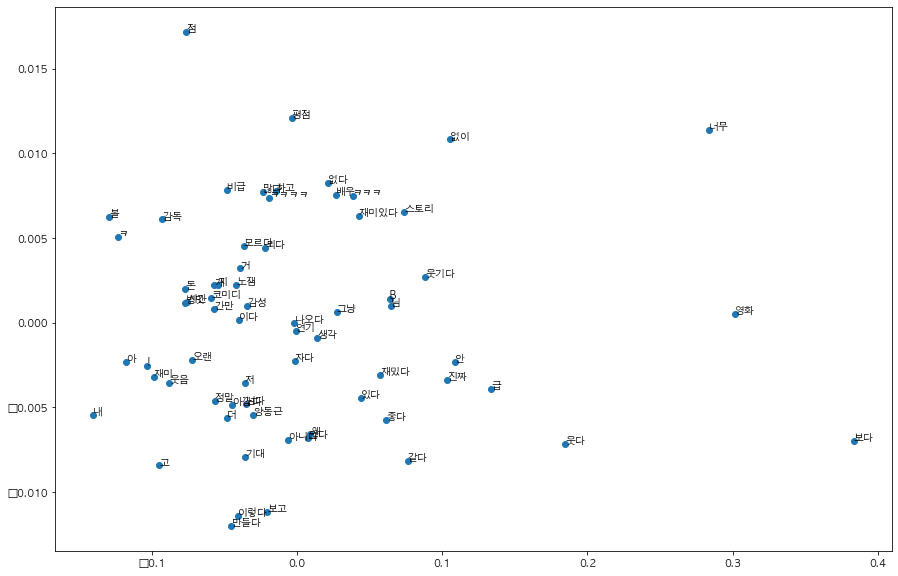

In [147]:
plt.figure(figsize=(15,10))
plt.scatter(xs, ys, marker='o')
for i, v in enumerate(vocabs):
    plt.annotate(v, xy=(xs[i], ys[i]))

In [154]:
from scipy import spatial
List1 = [3,4]
List2 = [-1,2]
result = 1 - spatial.distance.cosine(List1, List2)
print(result)

0.44721359549995787
